In [1]:
#Prototype for astropy pixel remap from HMI to PHI

In [2]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy import wcs
import astropy.wcs.utils as wcsutil
import astropy.units as u
import astropy.convolution as convolution
from astropy.coordinates import SkyCoord
import numpy as np
import sunpy.data.sample
import sunpy.map
from sunpy.coordinates import HeliographicCarrington, HeliographicStonyhurst, Heliocentric, Helioprojective, frames
from astropy.io import fits
import matplotlib.colors
from scipy import signal
from scipy import misc
import math
import json
import matplotlib as mpl
import sunpy.visualization.colormaps as cm
magmap = mpl.colormaps['hmimag']

import astropy.wcs.utils as wcsutil

from reproject_funcs import get_hrt_remapped_on_hmi

/scratch/slam/sinjan/.conda/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 12-10-23

#load HRT first blos
filedir = '/data/solo/phi/data/fmdb/public/l2/2023-10-12/'
bfile = 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz'
icfile = 'solo_L2_phi-hrt-icnt_20231012T001503_V202408291137_0350120601.fits.gz'

hrt_121023_ic_hdr = fits.getheader(filedir+icfile)

In [4]:
#load 12-10-23 wcs correction
with open('/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRVAL_corrections_20231012.json') as f:
    hrt_121023_wcs_err = json.load(f)

fileDID = hrt_121023_ic_hdr['PHIDATID']
crval_err = hrt_121023_wcs_err[fileDID]

In [5]:
hrt_121023_icm = sunpy.map.Map(filedir+icfile)
hrt_121023_icm.reference_coordinate

<SkyCoord (Helioprojective: obstime=2023-10-12T00:15:44.523, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:15:44.523, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-78.266917, 1.8157965, 4.66449761e+10)>): (Tx, Ty) in arcsec
    (338.6472, 387.539)>

In [6]:
crval_errx_arcsec=-crval_err[0]*u.arcsec
crval_erry_arcsec=-crval_err[1]*u.arcsec
hrt_121023_icm=hrt_121023_icm.shift_reference_coord(crval_errx_arcsec.to(u.deg),crval_erry_arcsec.to(u.deg))
print("Added items:", hrt_121023_icm.meta.added_items)
print("Removed items:", hrt_121023_icm.meta.removed_items)
print("Modified items:", hrt_121023_icm.meta.modified_items)

Added items: {}
Removed items: {}
Modified items: {'crval1': (original=338.6472, current=340.5814149257504), 'crval2': (original=387.539, current=273.7518884550109)}


In [7]:
hmifiledir = '/scratch/slam/sinjan/arlongterm_hmi/'
hmibfile = 'blos_45/hmi.m_45s.20231012_002145_TAI.2.magnetogram.fits'
hmiicfile = 'ic_45/hmi.ic_45s.20231012_002145_TAI.2.continuum.fits'

In [8]:
hmi_121023_b = sunpy.map.Map(hmifiledir+hmibfile).rotate()
hmi_121023_b_hdr = hmi_121023_b.meta

hmi_121023_ic = sunpy.map.Map(hmifiledir+hmiicfile).rotate()
hmi_121023_ic_hdr = hmi_121023_ic.meta

In [9]:
x,y=range(hmi_121023_ic.data.shape[1]),range(hmi_121023_ic.data.shape[0])
X,Y = np.meshgrid(x,y)

In [10]:
x

range(0, 4102)

In [11]:
out=wcsutil.pixel_to_skycoord(X,Y,hmi_121023_ic.wcs)

In [12]:
out2=wcsutil.skycoord_to_pixel(out,hrt_121023_icm.wcs)
out2

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

In [13]:
type(out2[0])
xarr = out2[0]
yarr = out2[1]

In [14]:
xarr[xarr > 1792] = np.nan
xarr[xarr <= 0] = np.nan
xarr[yarr > 1792 ] = np.nan
xarr[yarr <= 0 ] = np.nan

yarr[np.isnan(xarr)] = np.nan

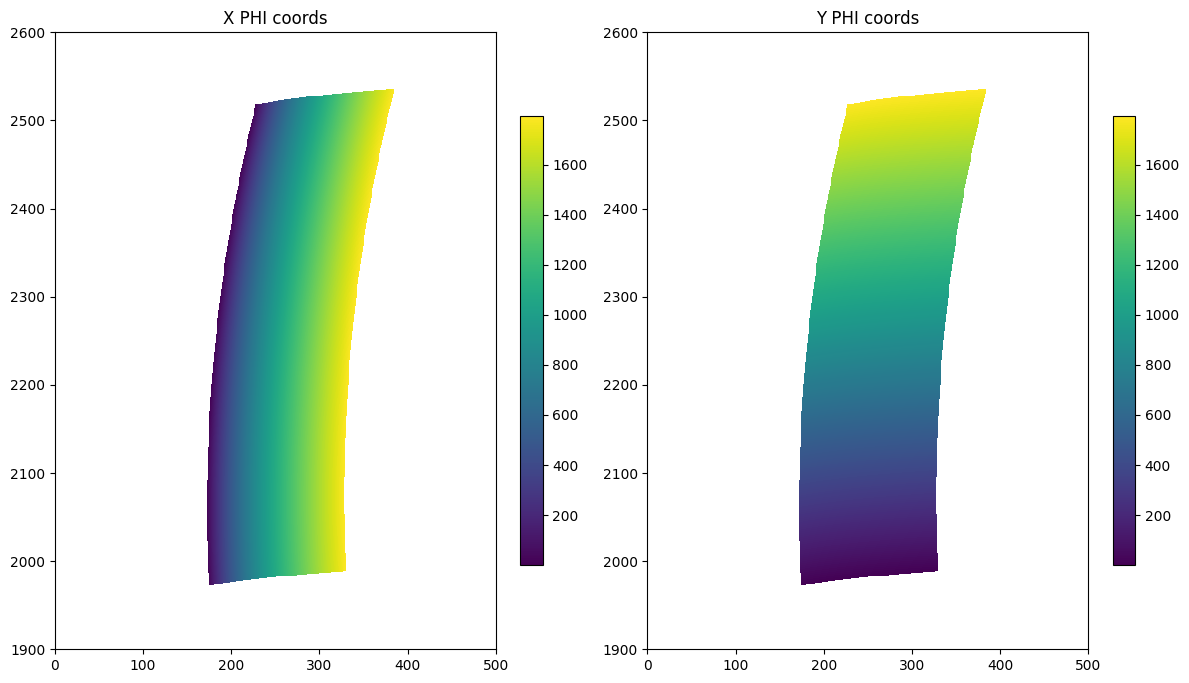

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(xarr,origin="lower")
plt.title('X PHI coords')
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.colorbar(fraction=0.046)

plt.subplot(122)
plt.imshow(yarr,origin="lower")
plt.title('Y PHI coords')
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.colorbar(fraction=0.046)
plt.tight_layout()

In [16]:
#get mask map from one of these arrays
#overplot on HMI ic
#compare with mask map from reproject, check the edges

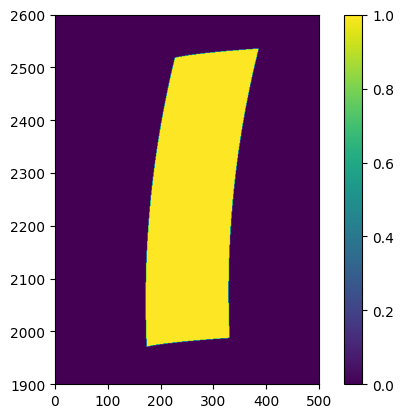

In [17]:
mask_map = np.where(np.isnan(xarr),0,1)
plt.imshow(mask_map,origin="lower")
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.colorbar()

In [19]:
#reproject mask

hrt_remap,hmi_map = get_hrt_remapped_on_hmi(filedir+icfile, hmifiledir+hmiicfile, err=crval_err,\
                                            reproject_args = {'kernel': 'Gaussian', 'kernel_width': 10000,'sample_region_width': 1})

2025-01-21 12:27:46.698163
2025-01-21 12:28:10.319987


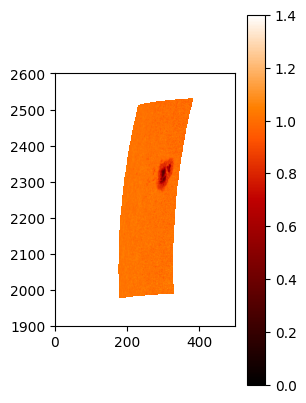

In [22]:
plt.figure()
plt.subplot(121)
plt.imshow(hrt_remap.data,origin="lower",cmap='gist_heat',vmin=0,vmax=1.4)
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.colorbar()
plt.show()

In [23]:
reproj_mask = np.where(np.isnan(hrt_remap.data),0,1)

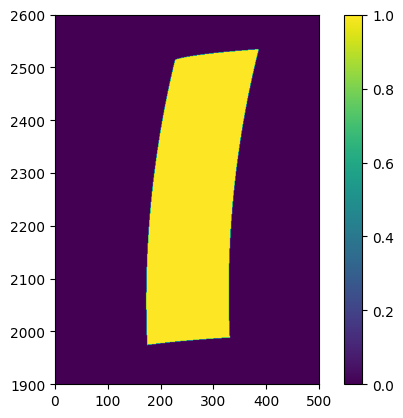

In [32]:
plt.imshow(reproj_mask,origin="lower")
plt.xlim(0,500)
plt.ylim(1900,2600)
plt.colorbar()

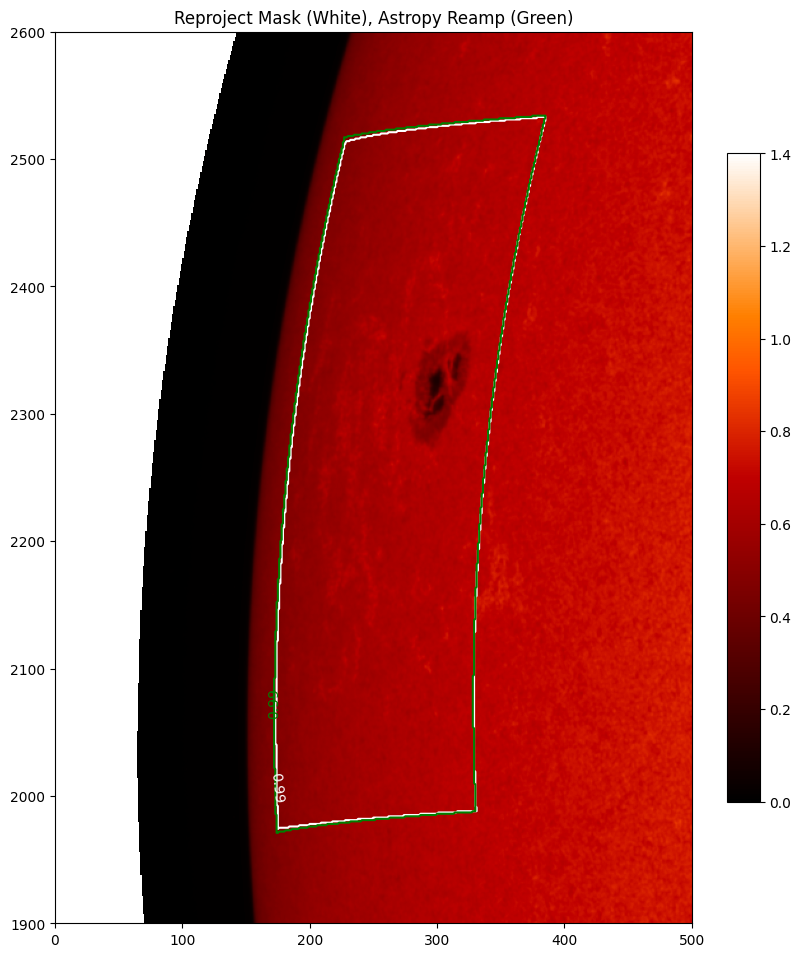

In [55]:
plt.figure(figsize=(20,20))
plt.subplot(121)
im1=plt.imshow(hmi_map.data/50000,origin="lower",cmap='gist_heat',vmin=0,vmax=1.4)
CS=plt.contour(reproj_mask,levels=[0.99],colors='white')
plt.clabel(CS,inline=False)
CS2=plt.contour(mask_map,levels=[0.99],colors='green')
plt.clabel(CS2,inline=False)
plt.xlim(0,500)
plt.ylim(1900,2600)

plt.colorbar(im1,fraction=0.046)
#plt.legend()
plt.title('Reproject Mask (White), Astropy Reamp (Green)')
plt.show()

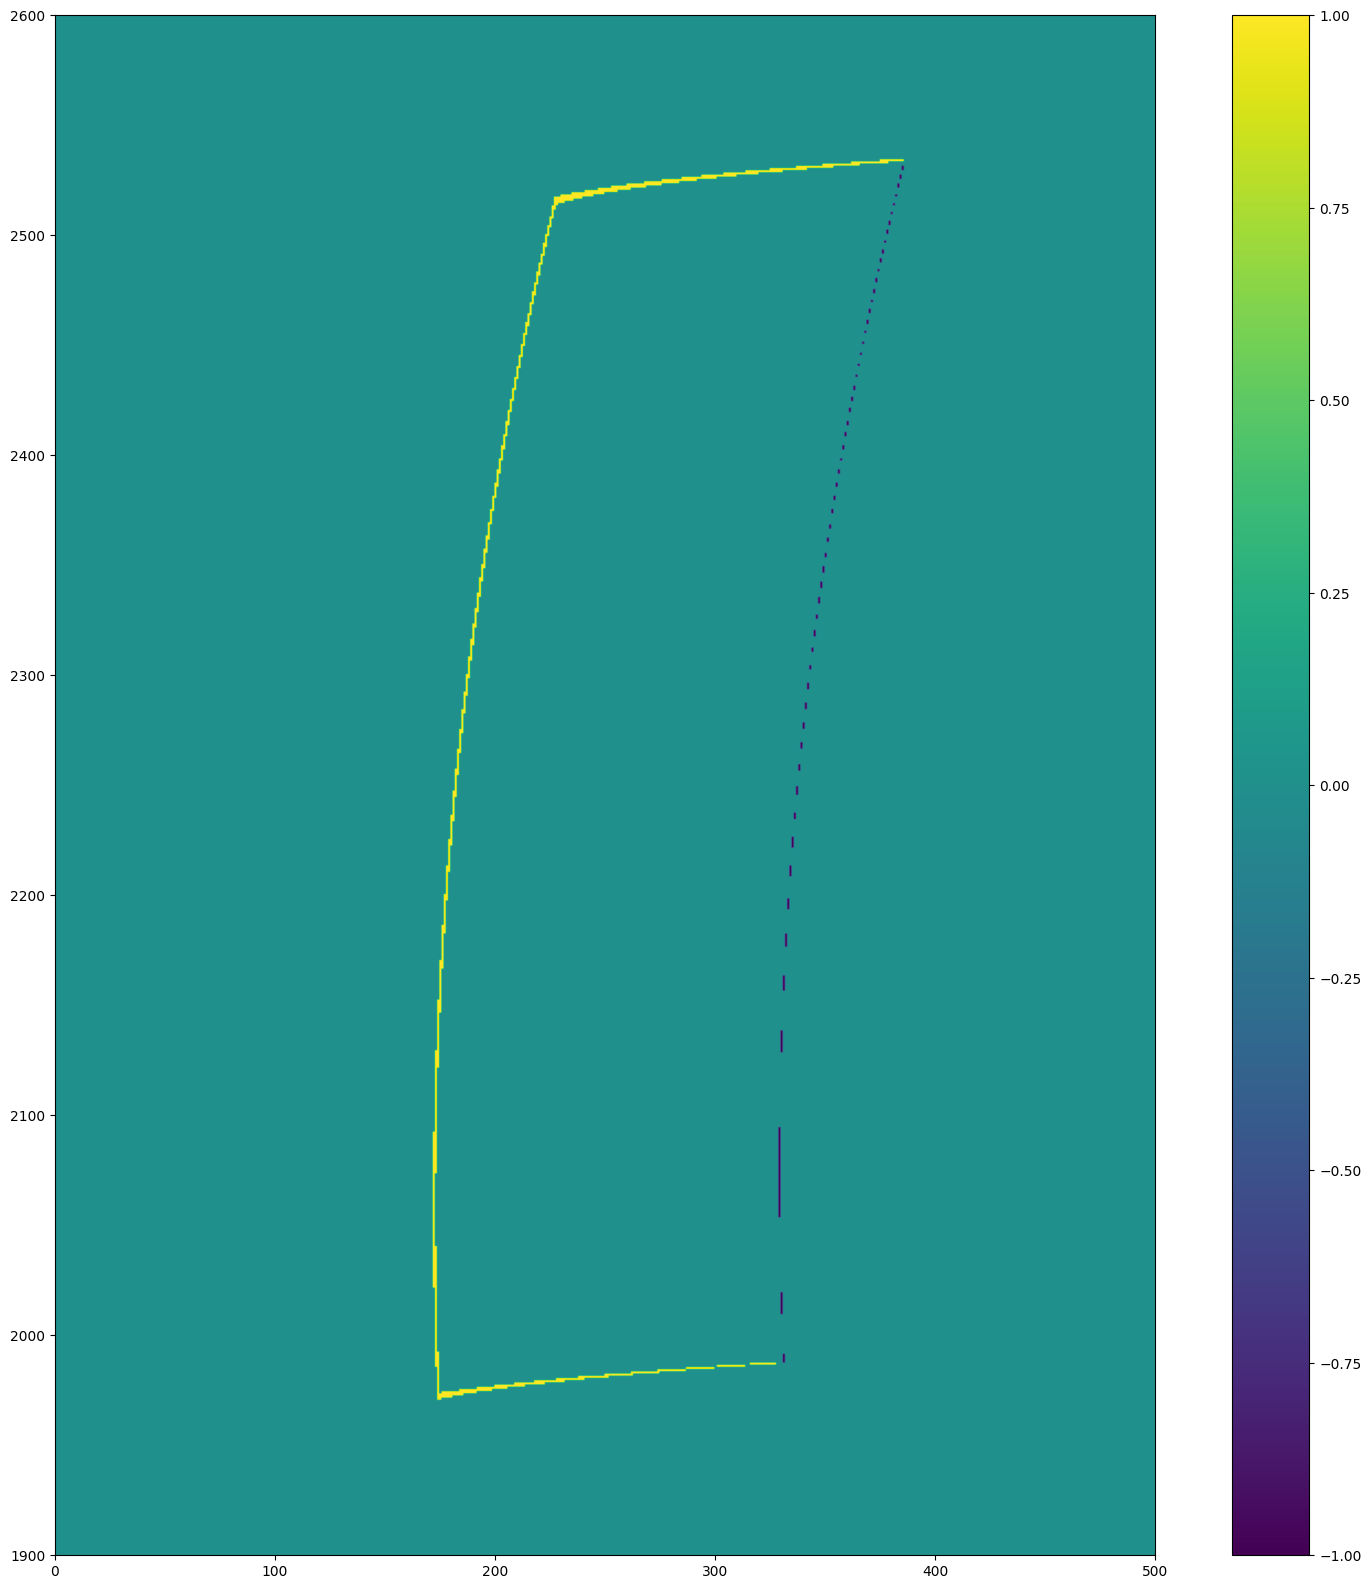

In [66]:
#where diff map 1, astropy mask found pixels, but reproject did not - reproject discards pixels where some in HRT are outside
#where diff map -1, reproject found pixels, but astropy did not - much less on the disc centre side
plt.figure(figsize=(20,20))
plt.imshow(mask_map-reproj_mask,origin="lower")
plt.xlim(0,500)
plt.ylim(1900,2600)
# plt.xlim(300,390)
# plt.ylim(2400,2550)
plt.colorbar()

In [ ]:
plt.imshow(mask_map-reproj_mask,origin="lower")
plt.xlim(160,200)
plt.ylim(1960,2000)
plt.colorbar()

In [ ]:
#but overall not too bad between the two
#think it is perhaps then just more how the values are combined